
Celem projektu jest analiza danych dotyczących udaru mózgu, znajdujących się w pliku `healthcare-dataset-stroke-data.csv`. Wyniki należy przedstawić w formie  raportu (RMarkdown, Jupyter, etc.) zawierającego kod programu jak i opisy dokonywanych decyzji. Analiza powinna zawierać co najmniej następujące punkty:

1. Czyszczenie danych (usuwanie/inputacja braków danych, naprawa błędów, transformacje danych, rozwiązanie problemu wartości odstających)
2. Eksploracyjna analiza danych
3. Zamodelowanie zmiennej `stroke` na podstawie pozostałych zmiennych. Minimum 3 modele.
4. Ewaluacja na zbiorze testowym (wybór modelu i metryk z uzasadnieniem)

Możliwe jest rozwiązaniem w języku R lub Python. Rozwiązania wysłać do 24.01.2022 na adres mailowy: michalmaj116@gmail.com z tytułem "studia podyplomowe"


# 1. Importy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, auc

# 2. Wczytanie danych

In [2]:
data_stroke = pd.read_csv("healthcare-dataset-stroke-data.csv", comment="#", sep=',')
data_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 3. Zrozumienie danych
##### Dane dotyczące udaru mózgu.
**id** -numer pacjenta

**gender** - płeć

**age** - wiek w latach

**hypertension** - nadciśnienie (0/1) 
 
**heart_disease** - choroba serca (0/1)

**ever_married** - czy pacjent był zonaty/zamężny (yes/no)

**Residence_type** - miejsce zamieszkania - urban - miejski, rural - wiejski

**work_type** - typ pracy - 5 rodzajów - self-employed(samozatrudniony), Govt_job - praca rządowa

**avg_glucose_level** -średni poziom glukozy, nie ma jednostek i skali??? (wg. 	eAG (mg/dL) - może być do 300
    Normal range: less than 114 mg/dL
    Prediabetes range: greater than 114 mg/dL and less than 140 mg/dL
    Diabetes range: greater than 140 mg/dL
    
**bmi** - bmi

**smoking_status** -formerly smoked - wcześniej palący

**stroke** - zmienna celu

In [3]:
type(data_stroke)
data_stroke.shape
data_stroke.columns
data_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
#INFORMACJE O DANYCH
#rózne typy danych - trzeba pozmieniać
#BMI - barkuje 201 kolumn - ?? - trzeba zrobić coś na NaNami
#zmienić hypertension, heart_disease, do ever_maried, work_type, residence_type, smiking_status zobiektowych na kategoryczne


In [5]:
#pozmieniam zmienne objekt na category - jak to zrobić w jednej linijce???
data_stroke.gender = data_stroke.gender.astype('category')
data_stroke.hypertension = data_stroke.hypertension.astype('category')
data_stroke.heart_disease = data_stroke.heart_disease.astype('category')
data_stroke.ever_married = data_stroke.ever_married.astype('category')
data_stroke.work_type = data_stroke.work_type.astype('category')
data_stroke.Residence_type = data_stroke.Residence_type.astype('category')
data_stroke.smoking_status = data_stroke.smoking_status.astype('category')
data_stroke.stroke = data_stroke.stroke.astype('category')

In [6]:
#usunięcie kolumny ID - nic nie wnosi
data_stroke.drop('id', axis=1, inplace=True)

In [7]:
#szukanie braków danych
data_stroke_nan_index = data_stroke.index[data_stroke.isnull().any(axis=1)]
data_stroke.iloc[data_stroke_nan_index]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
5039,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [13]:
#usuwanie/imputacja braków danych - wszystkich obserwacji 5110 (100%), więc 201 to będzie niecałe 4%, 
#zacznę od usunięcia i zobaczę co dalej będzie
data_stroke.dropna(inplace=True)
data_stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             4909 non-null   category
 1   age                4909 non-null   float64 
 2   hypertension       4909 non-null   category
 3   heart_disease      4909 non-null   category
 4   ever_married       4909 non-null   category
 5   work_type          4909 non-null   category
 6   Residence_type     4909 non-null   category
 7   avg_glucose_level  4909 non-null   float64 
 8   bmi                4909 non-null   float64 
 9   smoking_status     4909 non-null   category
 10  stroke             4909 non-null   category
dtypes: category(8), float64(3)
memory usage: 192.9 KB


In [14]:
#imputer = KNNImputer(n_neighbors=5)
#data_stroke_imputed = imputer.fit_transform(data_stroke)

#imp = SimpleImputer(strategy='mean')
#data_stroke_imp = imp.fit_transform(data_stroke)

In [16]:
#poznaje kolejne kolumny nietypowe
data_stroke.groupby('gender').count()
#gender ma male, female ( w miarę równo rozłożone) i kolumne inne(1 odczyt)

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,,,,,,,,,,
Female,2897,2897,2897,2897,2897,2897,2897,2897,2897,2897
Male,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
Other,1,1,1,1,1,1,1,1,1,1


In [17]:
data_stroke.drop(data_stroke[data_stroke['gender']=='Other'].index, inplace=True) ###tu usunąc tego other!!!
data_stroke.groupby('gender').count()

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,,,,,,,,,,
Female,2897,2897,2897,2897,2897,2897,2897,2897,2897,2897
Male,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
Other,0,0,0,0,0,0,0,0,0,0


In [20]:
data_stroke.groupby('ever_married').count()
#kolumny yes, no(trochę nierówno 1727:3353)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
ever_married,,,,,,,,,,
No,1704,1704,1704,1704,1704,1704,1704,1704,1704,1704
Yes,3204,3204,3204,3204,3204,3204,3204,3204,3204,3204


In [21]:
data_stroke.groupby('work_type').count()
#5 rodzajów - govt job - praca rządowa,

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
work_type,,,,,,,,,,
Govt_job,630,630,630,630,630,630,630,630,630,630
Never_worked,22,22,22,22,22,22,22,22,22,22
Private,2810,2810,2810,2810,2810,2810,2810,2810,2810,2810
Self-employed,775,775,775,775,775,775,775,775,775,775
children,671,671,671,671,671,671,671,671,671,671


In [22]:
data_stroke.groupby('Residence_type').count()
#tylko miejskie i wiejskie(równo ułożone)

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
Residence_type,,,,,,,,,,
Rural,2418,2418,2418,2418,2418,2418,2418,2418,2418,2418
Urban,2490,2490,2490,2490,2490,2490,2490,2490,2490,2490


In [23]:
data_stroke.groupby('smoking_status').count()
#4 rodzaje - w tym jeden - unknown

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke
smoking_status,,,,,,,,,,
Unknown,1483,1483,1483,1483,1483,1483,1483,1483,1483,1483
formerly smoked,836,836,836,836,836,836,836,836,836,836
never smoked,1852,1852,1852,1852,1852,1852,1852,1852,1852,1852
smokes,737,737,737,737,737,737,737,737,737,737


In [24]:
data_stroke.groupby('stroke').count()
#zmienna celu
#tu mamy dwa rodzaje - duża nierówność prawie 5000:250

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
stroke,,,,,,,,,,
0,4699,4699,4699,4699,4699,4699,4699,4699,4699,4699
1,209,209,209,209,209,209,209,209,209,209


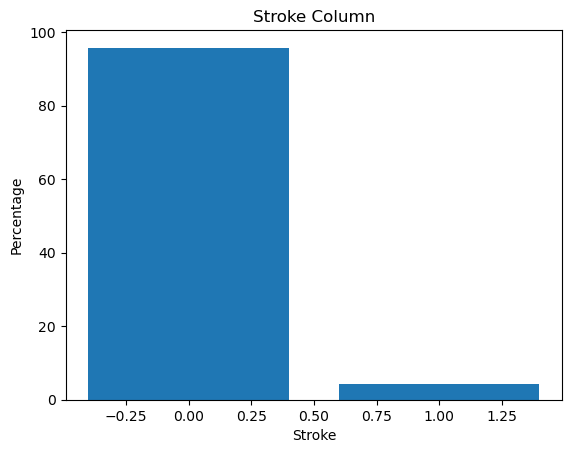

In [25]:
#Przy klasyfikacji jednym z najwazniejszych pytań podczas eksploracyjnej analizy danych 
#jest zbalansowanie zmiennej zaleznej a raczej jego brak. 
#W przypadku niezbalansowanych danych dużo trudniej jest zbudować dobrze działający klasyfikator.

counts = data_stroke['stroke'].value_counts()
percentages = counts / counts.sum() * 100

plt.bar(percentages.index, percentages.values) # zmienić na yes/no poziomą wartość
plt.title('Stroke Column')
plt.xlabel('Stroke')
plt.ylabel('Percentage')
plt.show()
#zmienna niezbilansowana????

In [26]:
#badam zmienne numeryczne
data_stroke.describe()

,age,avg_glucose_level,bmi
count,4908.000000,4908.000000,4908.00000
mean,42.868810,105.297402,28.89456
std,22.556128,44.425550,7.85432
min,0.080000,55.120000,10.30000
25%,25.000000,77.067500,23.50000
50%,44.000000,91.680000,28.10000
75%,60.000000,113.495000,33.10000
max,82.000000,271.740000,97.60000


# 4. Outliery 
wiek i glukoza wyglądają znośnie, BMI ma dziwne wyniki

poniżej 16 - wygłodzenie
16 - 16.99 - wychudzenie
17 - 18.49 - niedowagę
18.5 - 24.99 - wagę prawidłową
25.0 - 29.9 - nadwagę
30.0 - 34.99 - I stopień otyłości
35.0 - 39.99 - II stopień otyłości
powyżej 40.0 - otyłość skrajną


In [27]:
#Szukam outlierów metodą z_scores
data_stroke_imputed = pd.DataFrame(data_stroke, columns=['age', 'avg_glucose_level', 'bmi'])

means = np.mean(data_stroke_imputed, axis=0)
sds = np.std(data_stroke_imputed, axis=0)
z_scores = np.abs(data_stroke_imputed - means) / sds
outliers = np.where(z_scores > 3)

print(outliers)

(array([  27,   38,   62,   80,   94,  103,  104,  112,  125,  158,  161,
        182,  204,  216,  218,  230,  263,  290,  293,  302,  317,  344,
        388,  423,  498,  506,  517,  591,  616,  624,  659,  666,  704,
        710,  734,  872, 1003, 1009, 1012, 1019, 1053, 1144, 1164, 1235,
       1252, 1311, 1362, 1379, 1449, 1452, 1477, 1482, 1502, 1513, 1543,
       1573, 1797, 1965, 1975, 2019, 2027, 2073, 2093, 2146, 2161, 2180,
       2215, 2324, 2345, 2421, 2431, 2443, 2508, 2568, 2624, 2636, 2685,
       2708, 2781, 2917, 2944, 3087, 3186, 3233, 3235, 3320, 3347, 3426,
       3443, 3443, 3523, 3536, 3602, 3654, 3737, 3758, 3804, 3871, 3976,
       4009, 4029, 4045, 4068, 4167, 4172, 4223, 4262, 4271, 4284, 4289,
       4410, 4521, 4645, 4713, 4716, 4756, 4787, 4837], dtype=int64), array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1,
       2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2

In [28]:
data_stroke_imputed.iloc[outliers[0][outliers[1] == 2]]
data_stroke = data_stroke[data_stroke["bmi"] <= 52] #powyżej 60 to chyba niemożliwe 

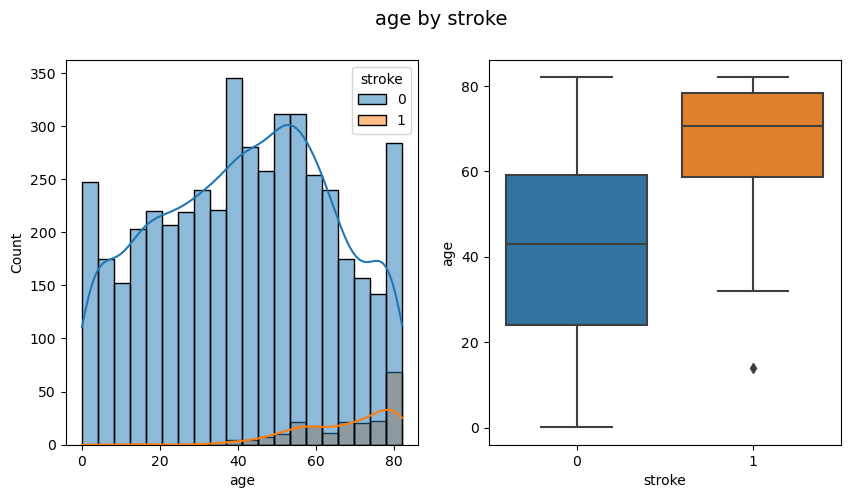

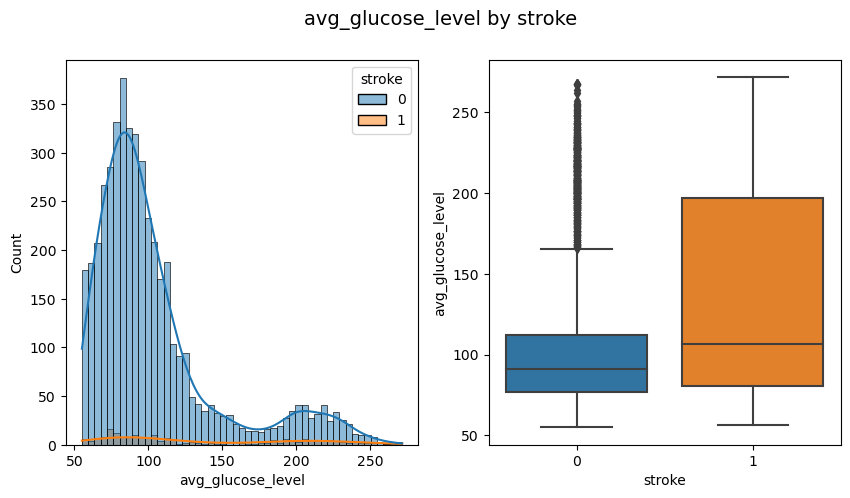

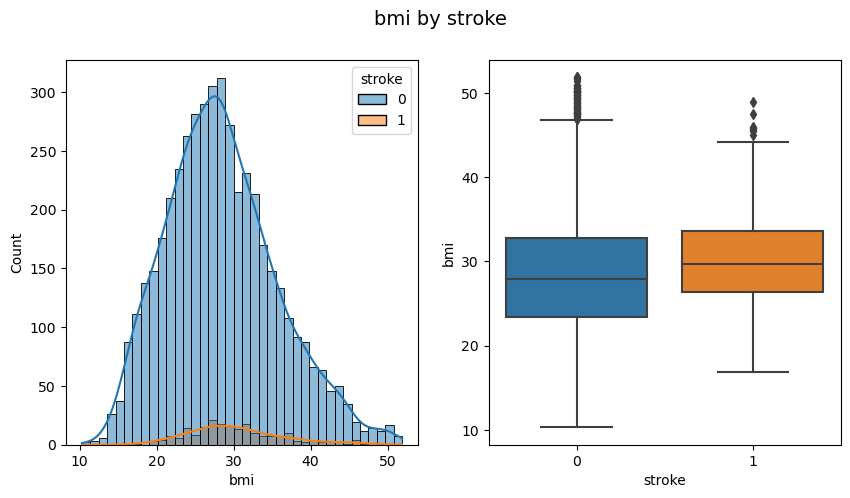

In [29]:
num_cols = ['age', 'avg_glucose_level', 'bmi']

for col in num_cols:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    sns.histplot(data=data_stroke, x=col, hue='stroke', kde=True, ax=ax1)
    sns.boxplot(data=data_stroke, x='stroke', y=col, ax=ax2)
    fig.suptitle(f'{col} by stroke', fontsize=14)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


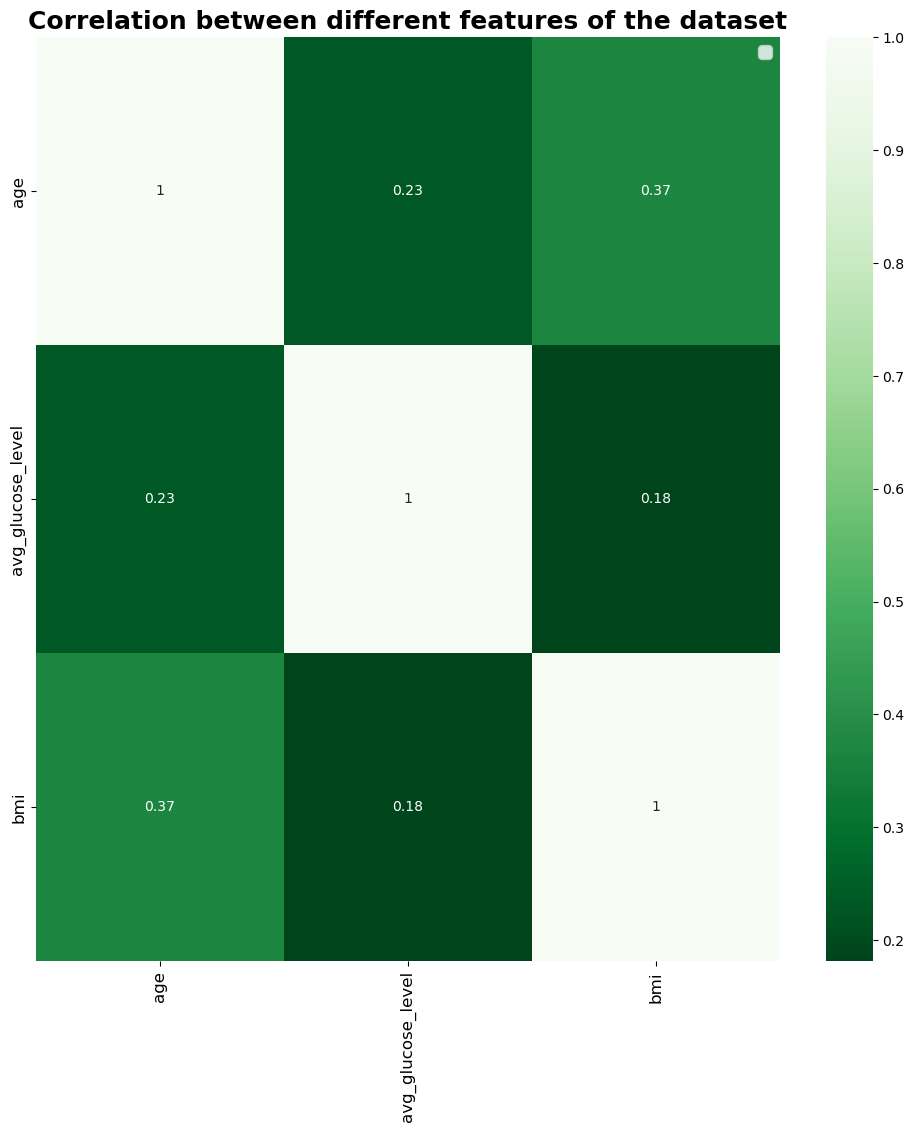

In [30]:
#Sprawdzam korelację pomiędzy zmiennymi  numerycznymi
plt.figure(figsize = (12,12))
plt.title("Correlation between different features of the dataset", fontsize = 18, fontweight = 'bold')
sns.heatmap(data_stroke.corr(numeric_only = True), cmap = 'Greens_r', annot = True)
plt.xticks(fontsize=12, rotation = 90)
plt.yticks(fontsize=12, rotation = 90)
plt.legend(fontsize=12)